In [16]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

# Comparison of sqcircuit composite vs full circuit model

In [84]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [85]:
C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]

In [86]:
nmax_r = 10
nmax_f = 10
CC = 10
only_inner = False
compensate_extra_cap = False
only_renormalization = False
n_eig = 6
φ_ext = 0.5
φ_ext_prime = 0.5

In [87]:
experiment_colors = ['b', 'g', 'r']
experiment_labels = ['Unit cell 1', 'Coupler', 'Unit cell 2']
colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

In [88]:
circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                      C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext,
                                      nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap, only_renormalization=only_renormalization)
circ_full.diag(n_eig)
E_full = circ_full.efreqs
E_full  = E_full-E_full[0]

In [89]:
C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)

In [90]:
CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
resonator       = sq_ext.sq_resonator(C_R_eff=CR_tilde,       L_R_eff=LR,       Δ=Δ,       EJ=EJ,       nmax_r=nmax_r)
fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
circuits = [fluxonium, resonator, fluxonium_prime,resonator_prime]
LCs = [LC, LC_prime]

In [91]:
H_qubit_C_qubit = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=False)
E_qubit_C_qubit= sq_ext.diag(H_qubit_C_qubit, n_eig,   remove_ground=True)[0]

In [92]:
H_fluxonium_C_fluxonium = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [circuits[0],circuits[2]], nmax_f=nmax_f, return_H_0=False)
E_fluxonium_C_fluxonium= sq_ext.diag(H_fluxonium_C_fluxonium, n_eig,   remove_ground=True)[0]

In [93]:
E_full, E_qubit_C_qubit, E_fluxonium_C_fluxonium

(array([0.000000000000, 2.742279214949, 3.275002178444, 3.917010763486, 5.765958100129, 6.274559323973]),
 array([0.000000000000, 2.742258451027, 3.274942237082, 3.917010489362, 5.765966270039, 6.274566760869]),
 array([0.000000000000, 2.743271064054, 3.278809932708, 5.768359238071, 7.531394503829, 7.809694932202]))

## Spectrum vs CC for the different models

In [47]:
def comp_spectrum_Q_c_Q_vs_φ_ext(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization):
    
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
    resonator       = sq_ext.sq_resonator(C_R_eff=CR_tilde,       L_R_eff=LR,       Δ=Δ,       EJ=EJ,       nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    circuits = [fluxonium, resonator, fluxonium_prime,resonator_prime]
    LCs = [LC, LC_prime]
    
    H_qubit_C_qubit = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=False)
    
    return sq_ext.diag(H_qubit_C_qubit, n_eig,   remove_ground=True)[0] 


In [43]:
def qubit_spectrum_Q_c_Q_vs_φ_ext(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization):
    
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    
    fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    circuits = [fluxonium, _, fluxonium_prime,_]
    
    H_fluxonium_C_fluxonium = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [circuits[0],circuits[2]], nmax_f=10, return_H_0=False)
    
    return sq_ext.diag(H_fluxonium_C_fluxonium, n_eig,   remove_ground=True)[0]


In [44]:
def full_spectrum_Q_c_Q_vs_φ_ext(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization):
    circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                          C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext_prime,
                                          nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap,only_renormalization=only_renormalization)
    circ_full.diag(n_eig)
    E = circ_full.efreqs
    return E-E[0]

In [76]:
nmax_r = 5
nmax_f = 10
CC = 10
only_inner = True
compensate_extra_cap = False
only_renormalization = False 

φ_ext_values = np.linspace(0.5, 1, 50)
# φ_ext_values_full = np.array([0.5, 0.522, 0.55, 0.58, 0.625, 0.67, 0.75])
φ_ext_values_full = np.array([0.5, 0.522, 0.58, 0.67, 0.75, 1])

In [77]:
E_composite = np.array(Parallel(n_jobs=10)( delayed(comp_spectrum_Q_c_Q_vs_φ_ext)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization) for φ_ext in φ_ext_values))

In [78]:
E_qubits  = np.array(Parallel(n_jobs=10)( delayed(qubit_spectrum_Q_c_Q_vs_φ_ext)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization) for φ_ext in φ_ext_values))

In [79]:
E_full  = np.array(Parallel(n_jobs=len(φ_ext_values_full))( delayed(full_spectrum_Q_c_Q_vs_φ_ext)(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, 
                                                                              C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext,
                                                                              nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization) for φ_ext in φ_ext_values_full))

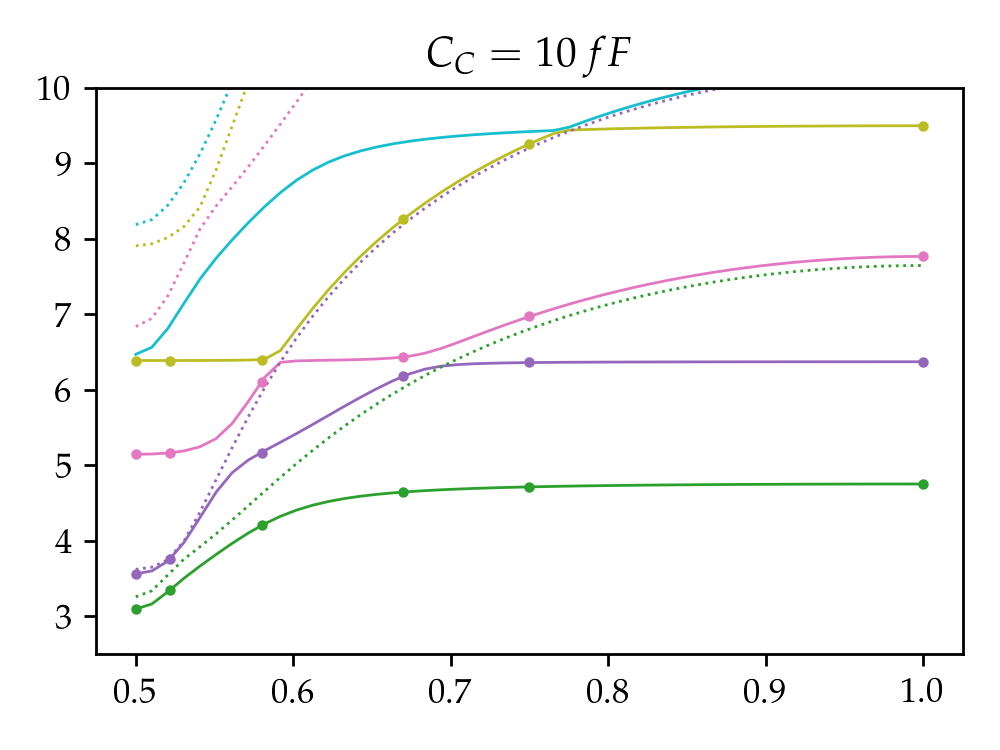

In [81]:
fig, ax = plt.subplots(figsize=[4,3], dpi=250)
# fig, ax = plt.subplots()
[ax.plot(φ_ext_values, E_composite[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values, E_qubits[:,i], ':', linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values_full, E_full[:,i],'o', color=colors[i], markersize=2) for i in range(5)]
# [ax.hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
ax.set_ylim([2.5, 10])
# ax.set_xlim([0.5, 0.75])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()

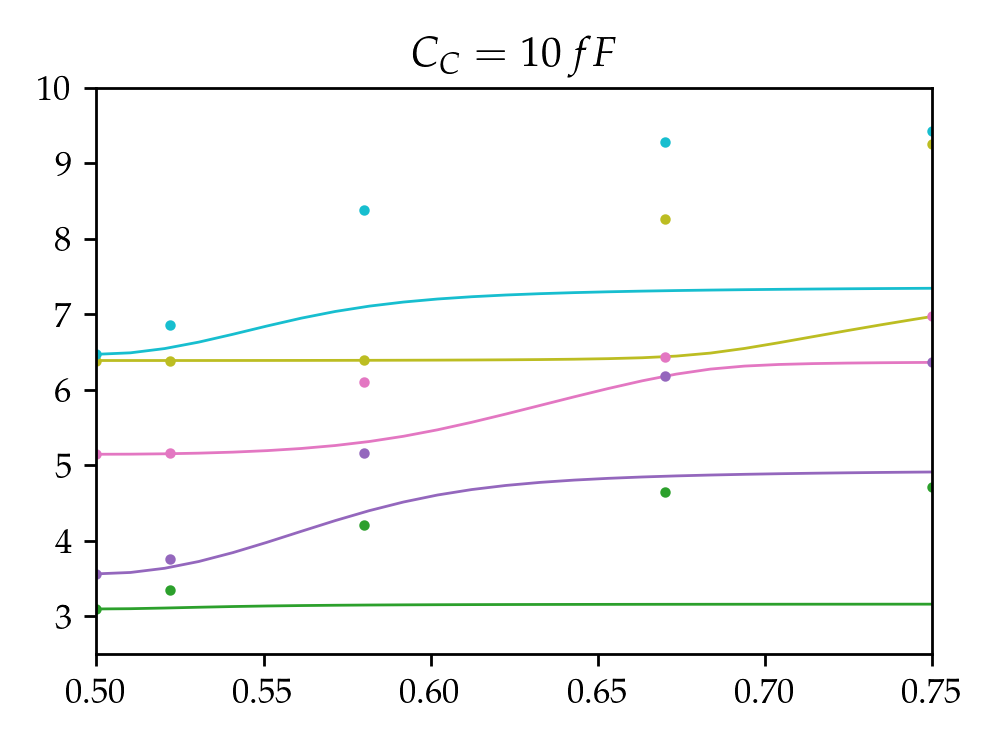

In [52]:
fig, ax = plt.subplots(figsize=[4,3], dpi=250)
# fig, ax = plt.subplots()
[ax.plot(φ_ext_values, E_composite[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values_full, E_full[:,i],'o', color=colors[i], markersize=2) for i in range(n_eig)]
# [ax.hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
ax.set_ylim([2.5, 10])
ax.set_xlim([0.5, 0.75])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()

In [37]:
plt.close('all')

In [38]:
E_composite_vs_CC_φ_ext = []
only_inner = True
compensate_extra_cap = False
only_renormalization = False 
CC_values = [0.1, 1, 10]
nmax_r = 5
nmax_f = 15
φ_ext_values  = np.linspace(0.5, 1, 100)
for CC in CC_values:
    E_composite_vs_CC_φ_ext.append( np.array(Parallel(n_jobs=100)( delayed(comp_spectrum_Q_c_Q_vs_φ_ext)(CC, CR, CF, LF, LR, EJ, Δ, φ_ext,
                                                                                  CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, φ_ext,
                                                                                  nmax_r, nmax_f, only_inner, compensate_extra_cap, only_renormalization) for φ_ext in φ_ext_values)) )

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 60 due to limitations of the operating system.
  warnings.warn(
Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\joblib\externals\loky\process_executor.py", line 596, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\joblib\externals\loky\process_executor.py", line 654, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\multiprocessing\connection.py", line 879, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeo

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(ncols = len(CC_values), figsize=np.array([3*len(CC_values),3]), dpi=250)

[axs[0].hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]

for ax, CC, E_composite_vs_φ_ext in zip(axs, CC_values, E_composite_vs_CC_φ_ext):
    [ax.plot(φ_ext_values, E_composite_vs_φ_ext[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
    ax.set_ylim([2.5, 10])
    ax.set_xlim([0.5, 0.75])
    #ax.set_ylabel(r'$')
    #ax.set_xlabel(r'$')
    #ax.set_title(r'$')
    ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()

In [ ]:
E_full_vs_CC_φ_ext = []
only_inner = True
compensate_extra_cap = False
only_renormalization = False 
CC_values = [0.1, 1, 10]
nmax_r = 5
nmax_f = 10
n_eig=5
φ_ext_values_full = np.linspace(0.5, 1, 50)

In [ ]:
for CC in CC_values:
    print(CC)
    E_full_vs_CC_φ_ext.append( np.array(Parallel(n_jobs=10)( delayed(full_spectrum_Q_c_Q_vs_φ_ext)(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, 
                                                                              C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext,
                                                                              nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization) for φ_ext in φ_ext_values_full)) )

In [ ]:
fig, axs = plt.subplots(ncols = len(CC_values), figsize=np.array([3*len(CC_values),3]), dpi=250)

[axs[0].hlines(ω_r, φ_ext_values_full.min(), φ_ext_values_full.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]

for ax, CC, E_full_vs_φ_ext in zip(axs, CC_values, E_full_vs_CC_φ_ext):
    [ax.plot(φ_ext_values_full, E_full_vs_φ_ext[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
    ax.set_ylim([2.5, 10])
    ax.set_xlim([0.5, 1])
    #ax.set_ylabel(r'$')
    #ax.set_xlabel(r'$')
    #ax.set_title(r'$')
    ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
# figs.export('Spectrum_vs_CC.pdf', fig)
fig.show()

In [ ]:
fig, axs = plt.subplots(ncols = len(CC_values), figsize=np.array([3*len(CC_values),3]), dpi=250)

[axs[0].hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]

for ax, CC, E_full_vs_φ_ext in zip(axs, CC_values, E_full_vs_CC_φ_ext):
    [ax.plot(φ_ext_values_full, E_full_vs_φ_ext[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
    ax.set_ylim([2.5, 10])
    ax.set_xlim([0.5, 1])
    #ax.set_ylabel(r'$')
    #ax.set_xlabel(r'$')
    #ax.set_title(r'$')
    ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()